# *Lux*: Getting Started (Demo with Simulated Data)

In this tutorial, we will demonstrate how to define a [_Lux_](https://arxiv.org/abs/2502.01745) model with two outputs using the {py:class}`~pollux.models.LuxModel` class. We will use simulated data, but the outputs are meant to loosely represent (1) stellar labels, like element abundances, stellar parameters, etc., and (2) stellar spectra (fluxes) on a wavelength-aligned grid of pixels. For the model, we will use a bi-linear structure in which both outputs are generated as linear transformations of a latent representation of each star. We will use a latent dimensionality that is larger than the number of stellar labels but much smaller than the number of pixels in the spectra.

We will start with some standard imports and set up the simulated data.

In [51]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.distributions.constraints import real
import pandas as pd

import pollux as plx
from pollux.models.transforms import LinearTransform

jax.config.update("jax_enable_x64", True)

## Generating simulated data

We will generate data for 2048 stars, with a latent dimensionality of 8, but only 2 labels and 128 pixels in the spectra. We will define the linear transformations that generate the simulated labels and spectra to have some strict structure: the first 2 latent dimensions will be used to generate the labels, and will correlate with the strength of Gaussian "spectral lines" in the simulated spectra. This is purely for demonstration purposes, and we could instead have used random linear transformations (e.g., with all elements of the transform matrices drawn from a Normal or uniform distribution).

In [52]:
n_all_stars = 11067
n_stars = 100  # number of simulated stars to generate in the train and test sets
n_labels = 4  # number of labels to generate per star
#n_latents = n_labels * 4  # size of the latent vector per star
n_latents = 8
n_flux = 2401  # number of spectral flux pixels per star

rng = np.random.default_rng(seed=8675309)

A = np.zeros((n_labels, n_latents))
A[0, 0] = 1.0
A[1, 1] = 1.0

B = rng.normal(scale=0.1, size=(n_flux, n_latents))
B[:, 0] = B[:, 0] + 4 * np.exp(-0.5 * (np.arange(n_flux) - n_flux / 2) ** 2 / 5**2)
B[:, 1] = B[:, 1] + 2 * np.exp(-0.5 * (np.arange(n_flux) - n_flux / 4) ** 2 / 3**2)

let's assume labels here are [Fe/H] and Teff

In [ ]:
han_test_set = pd.read_pickle('test_set_all_params.pkl')
han_test_set = han_test_set[:n_stars]

In [54]:
han_test_set.columns

Index(['flux', 'flux_error', 'source_id', 'teff', 'logg', 'fe_h', 'c_h', 'n_h',
       'o_h', 'mg_h', 'al_h', 'si_h', 'ca_h', 'mn_h', 'ni_h', 'e_teff',
       'e_logg', 'e_fe_h', 'e_c_h', 'e_n_h', 'e_o_h', 'e_mg_h', 'e_al_h',
       'e_si_h', 'e_ca_h', 'e_mn_h', 'e_ni_h'],
      dtype='object')

In [55]:
#params_paper = ['teff', 'logg', 'fe_h', 'c_h', 'n_h', 'o_h', 'mg_h', 'al_h', 'si_h', 'ca_h', 'mn_h', 'ni_h']
#params_paper = ['teff', 'logg', 'fe_h', 'o_h', 'mg_h','si_h']
params_paper = ['teff', 'logg', 'fe_h', 'mg_h']
# List of error column names corresponding to params_paper
params_errors = [f"e_{p}" if not p.startswith('e_') else p for p in params_paper]

# Stack columns for labels
han_labels = np.column_stack([han_test_set[p] for p in params_paper])

# Stack columns for errors
han_label_errs = np.column_stack([han_test_set[e] for e in params_errors])

In [56]:
han_labels.shape

(100, 4)

In [57]:
han_dict = {
    'label': han_labels,
    'label_err': han_label_errs,
    'flux': han_test_set['flux'].tolist(),
    'flux_err': han_test_set['flux_error'].tolist()
}

In [58]:
han_dict['flux'] = np.vstack([f.filled(1) if isinstance(f, np.ma.MaskedArray) else f
                              for f in han_dict['flux']])

# Convert flux_err list to 2D array
han_dict['flux_err'] = np.vstack([f.filled(9999) if isinstance(f, np.ma.MaskedArray) else f
                                  for f in han_dict['flux_err']])

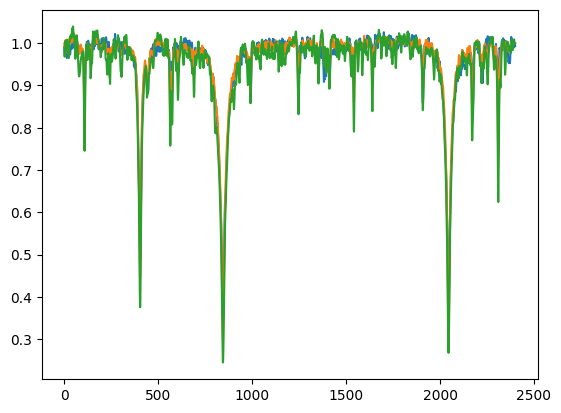

In [59]:
plt.plot(han_dict['flux'][1])
plt.plot(han_dict['flux'][0])
plt.plot(han_dict['flux'][2])

The data have simulated uncertainties, which the {py:class}`pollux.models.LuxModel` will use to define the likelihoods for the labels and spectra. Here are a few examples of the simulated spectra, ordered by (and colored by) the value of the first (0th index) label:

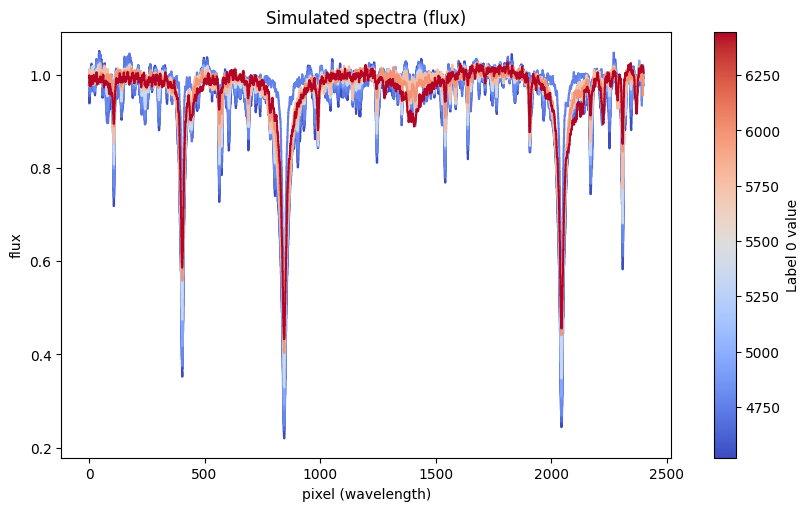

In [60]:
cmap = plt.get_cmap("coolwarm")
norm = mpl.colors.Normalize(
    vmin=han_dict["label"][:, 0].min(), vmax=han_dict["label"][:, 0].max()
)
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")

idx = np.argsort(han_dict["label"][:, 0])
for i in np.linspace(0, len(idx) - 1, 16).astype(int):
    ax.plot(
        han_dict["flux"][idx[i]],
        marker="",
        drawstyle="steps-mid",
        color=cmap(norm(han_dict["label"][idx[i], 0])),
    )
ax.set(xlabel="pixel (wavelength)", ylabel="flux", title="Simulated spectra (flux)")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=ax)
cb.set_label("Label 0 value")

plt.show()

To use this data with the {py:class}`~pollux.models.LuxModel`, we will need to define a {py:class}`~pollux.data.PolluxData` instance. This object acts as a container for the data and uncertainties, and also provides a mechanism to define "pre-processors" for the data. In this case, we will define pre-processors that normalize the labels and spectra to have zero mean and unit variance:

In [61]:
all_han_data = plx.data.PolluxData(
    flux=plx.data.OutputData(
        han_dict["flux"],
        err=han_dict["flux_err"],
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(han_dict["flux"]),
    ),
    label=plx.data.OutputData(
        han_dict["label"],
        err=han_dict["label_err"],
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(han_dict["label"]),
    ),
)

preprocessed_data = all_han_data.preprocess()

For this example, we will use the _Lux_ model in a "supervised" or "train and apply" mode, in which we will train the model on a subset of the data and then apply it to the remaining data. We will use the first 1024 stars for training and the remaining 1024 stars for testing (since they are not ordered in any way):

In [62]:
train_data = preprocessed_data[: n_stars // 2]
test_data = preprocessed_data[n_stars // 2 :]
len(train_data), len(test_data)

(50, 50)

## Constructing the _Lux_ model

We create a _Lux_ model by first defining a {py:class}`~pollux.models.LuxModel` instance with a specified latent dimensionality. In this case, we know that the data were generated with a latent dimensionality of 8, so we will use that value in this example:

In [63]:
model = plx.LuxModel(latent_size=n_latents)

In [92]:
n_latents

8

We then have to tell the model about the outputs (i.e. predict data) using the {py:meth}`~pollux.models.LuxModel.register_output` method. For this method, we specify an output name and a transform that specifies how the output will be generated from the latent representation. We currently have a few built-in transforms ({py:class}`~pollux.models.transforms.LinearTransform`, {py:class}`~pollux.models.transforms.AffineTransform`, and {py:class}`~pollux.models.transforms.QuadraticTransform`), but plan to add more in the future. We note that it is possible to define custom transforms by subclassing the {py:class}`~pollux.models.transforms.AbstractTransform` class.

In this example, we will use linear transformations (using {py:class}`~pollux.models.transforms.LinearTransform`) for both outputs of our demo model. We can define the transforms by, at minimum, specifying the output dimensionality for each output. In this case, the output names should match the names of the blocks in the data:

In [64]:
all_data = all_han_data

print(all_data.keys())  # noqa: T201
model.register_output("label", LinearTransform(output_size=n_labels))
model.register_output("flux", LinearTransform(output_size=n_flux))

dict_keys(['flux', 'label'])


With no other arguments, the {py:class}`~pollux.models.transforms.LinearTransform` will generate a linear transformation matrix and use a {py:class}`~numpyro.distributions.continuous.Normal` prior for the elements of the matrix with zero mean and unit variance. When optimizing, this is equivalent to placing an L2 regularization on the elements of the matrix. However, we can also override the default prior by specifying the `param_priors` argument to the {py:class}`~pollux.models.transforms.LinearTransform` initializer. This argument should be a dictionary with keys that match the names of the parameters in the transform and values that are instances of {py:class}`~numpyro.distributions.distribution.Distribution`. For the {py:class}`~pollux.models.transforms.LinearTransform`, the parameter name is `A` and this represents the matrix that maps latent dimensionality to output dimensionality.

For example, if we wanted to use an L2 regularization with a different regularization strength `alpha`, we could specify a different prior for `A`:

In [65]:
alpha = 100.0
trans = LinearTransform(
    output_size=n_labels, param_priors={"A": dist.Normal(0.0, jnp.sqrt(1 / alpha))}
)

Or, to disable regularization entirely, we could instead specify a {py:class}`~numpyro.distributions.distribution.ImproperUniform` prior:

In [66]:
trans = LinearTransform(
    output_size=n_labels, param_priors={"A": dist.ImproperUniform(real, (), ())}
)

For this example, we will proceed with the default priors for the linear transformation matrix elements.

As an initial test of the using the model, we will generate random values for latent vectors and the linear transform parameters and use the {py:meth}`~pollux.models.LuxModel.predict_outputs` method to generate predictions for the labels and spectra. These predictions will be meaningless in practice, because we have not yet optimized the parameters of the model, but they will demonstrate the structure of the model:

In [67]:
rngs = jax.random.split(jax.random.PRNGKey(42), 3)

# For this demo, we'll generate outputs for 10 objects
latents = jax.random.normal(rngs[0], shape=(10, model.latent_size))
pars = {
    "label": {"A": jax.random.normal(rngs[1], shape=(n_labels, model.latent_size))},
    "flux": {"A": jax.random.normal(rngs[2], shape=(n_flux, model.latent_size))},
}
outputs = model.predict_outputs(latents, pars)
outputs["label"].shape, outputs["flux"].shape

((10, 4), (10, 2401))

Later, once we have optimized the parameters of the model, we can use this method to generate predictions for new or held-out data, or to validate the model.

## Optimizing the model with training data (i.e. training the model)

As mentioned above, in this demonstration, we will use the first 1024 stars for training the model and the remaining 1024 stars for testing the model performance. We will optimize the model parameters using the training data and then evaluate the model on the test data and compare with the true values.

We will use the {py:meth}`~pollux.models.LuxModel.optimize` method to optimize the model parameters, which uses `numpyro`'s [MAP estimation functionality](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoDelta) under the hood. This model has a large number of parameters: the elements of each linear transformation matrix — (2, 8) and (128, 8) in shape — along with the latent vectors for each star. We therefore need to use an optimizer that can handle a large number of parameters. We have found that the {py:class}`~numpyro.optim.Adam` optimizer works well for this purpose. We run the optimizer for 10,000 steps:

In [68]:
opt_pars, svi_results = model.optimize(
    train_data,
    rng_key=jax.random.PRNGKey(112358),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    svi_run_kwargs={"progress_bar": False},
)
svi_results.losses.block_until_ready()

Array([1588586.14880675, 1585728.19356039, 1582889.77690735, ...,
         98590.9604988 ,   98590.88116902,   98590.80192532],      dtype=float64)

Let's check the loss trajectory for the last 1000 steps to see if (visually) the optimization has converged:

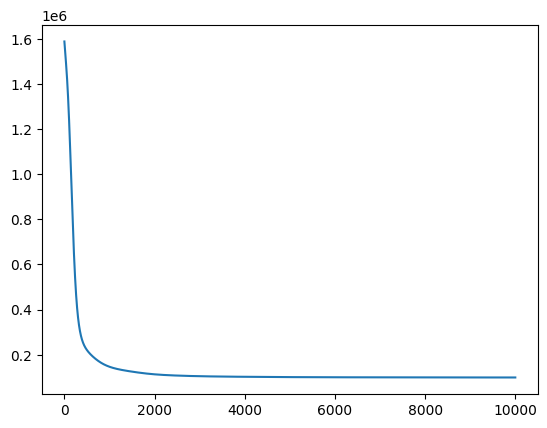

In [69]:
plt.plot(svi_results.losses[-10000:])
plt.show()

The loss is still decreasing, but much slower than in the first epochs. We therefore might want to run the optimizer for more steps, but for this demonstration, we will proceed with the current optimization.

We now have optimized linear transformation matrices and latent vectors for the training data:

In [70]:
opt_pars["label"], opt_pars["flux"]

({'data': {'A': Array([[-4.06825471e-01, -2.79064181e-01, -4.39186940e-01,
           -3.46017335e-01,  1.42689343e-01,  2.78988313e-03,
           -3.53720405e-04,  3.93305239e-02],
          [-3.24308045e-01, -9.95346455e-02, -6.35116999e-01,
           -3.80330063e-01, -9.47018646e-02, -4.64825616e-01,
           -2.23493584e-01, -5.32984516e-02],
          [ 2.61000469e-01, -2.04620537e-01, -2.93605775e-01,
           -8.92641198e-04, -1.93165139e-04, -2.24073287e-01,
            6.23665753e-02,  3.71131525e-01],
          [ 2.48406208e-01, -9.67439831e-02, -2.39867526e-01,
           -1.95052089e-01, -1.67715099e-01, -2.11194664e-01,
            2.10947730e-03,  3.72754970e-01]], dtype=float64)},
  'err': {}},
 {'data': {'A': Array([[-0.31586474, -0.22223743, -0.26195421, ...,  0.40607759,
           -0.30289916,  0.01835292],
          [-0.3639189 ,  0.10034364, -0.21630692, ...,  0.30252706,
           -0.23510416, -0.17807523],
          [-0.25301629,  0.11050229, -0.17256869, 

As we saw above, we can use the {py:meth}`~pollux.models.LuxModel.predict_outputs` method to generate predictions for the training data given the optimized latent vectors:

In [71]:
predict_train_values = model.predict_outputs(opt_pars["latents"], opt_pars)

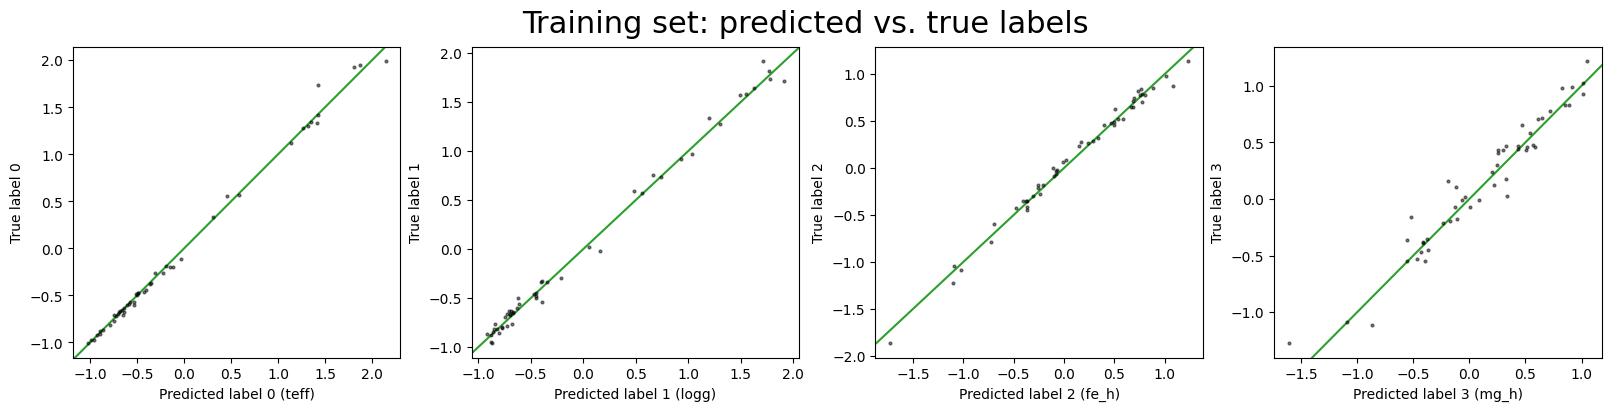

In [72]:
pt_style = {"ls": "none", "ms": 2.0, "alpha": 0.5, "marker": "o", "color": "k"}

fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(predict_train_values["label"].shape[1]):
    axes[i].plot(
        predict_train_values["label"][:, i], train_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i} ({params_paper[i]})", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Training set: predicted vs. true labels", fontsize=22)

plt.show()

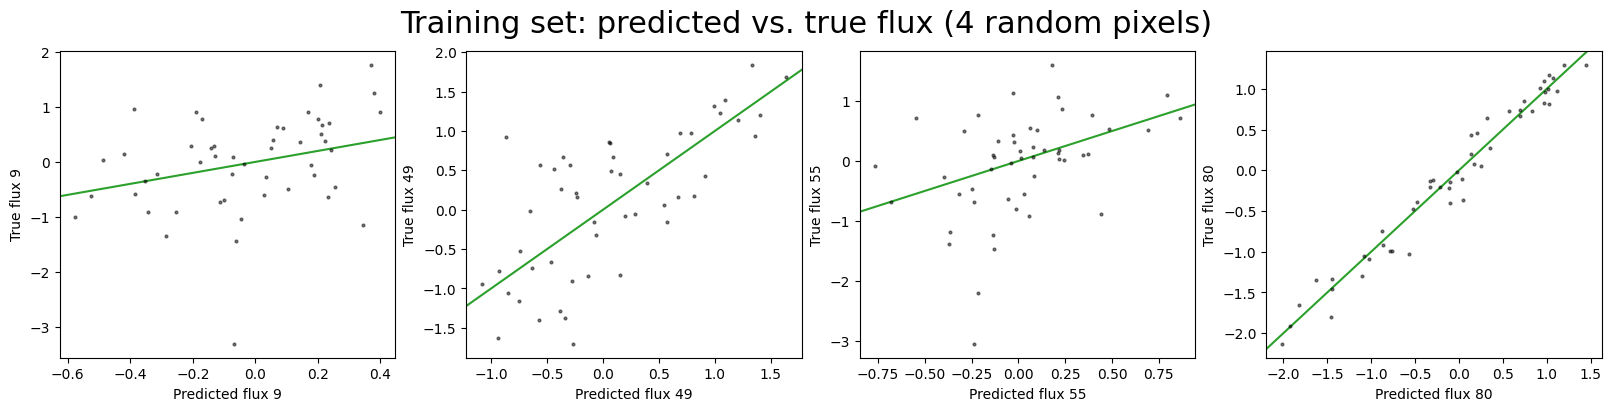

In [89]:
# Pick some random pixel values to compare:
pixel_idx = np.array([9, 49, 55, 80])

fig, axes = plt.subplots(
    1, len(pixel_idx), figsize=(4 * n_labels, 4), layout="constrained"
)
for i, j in enumerate(pixel_idx):
    axes[i].plot(
        predict_train_values["flux"][:, j], train_data["flux"].data[:, j], **pt_style
    )
    axes[i].set(xlabel=f"Predicted flux {j}", ylabel=f"True flux {j}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle(
    f"Training set: predicted vs. true flux ({len(pixel_idx)} random pixels)",
    fontsize=22,
)

plt.show()

Both the predicted training set labels and fluxes look reasonable, which is a good sign that the model has learned the structure of the data. However, we also want to evaluate the model on the test data, which the model has not seen during optimization.


## Optimize for latents for test set

To predict labels and fluxes for the test set, we need to optimize the latent vectors for the test set. When we do this, we want to hold fixed the linear transformation matrices we learned from the training set data. We can do this using the {py:meth}`~pollux.models.LuxModel.optimize` method using the `fixed_pars` argument to specify values to fix a subset of the model parameters. In this case, we will fix the linear transformation matrices to the values we learned from the training set data:

In [74]:
fixed_pars = {
    "label": {"data": {"A": opt_pars["label"]["data"]["A"]}},
    "flux": {"data": {"A": opt_pars["flux"]["data"]["A"]}},
}

Now, when we run the optimizer, it will only optimize the latent vectors for the test set data:

In [75]:
test_opt_pars, test_svi_results = model.optimize(
    test_data,
    rng_key=jax.random.PRNGKey(12345),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    fixed_pars=fixed_pars,
    svi_run_kwargs={"progress_bar": False},
)
test_svi_results.losses.block_until_ready()

Array([891184.52213538, 889381.69944936, 887582.45214107, ...,
       146457.7925633 , 146457.70519785, 146457.6179155 ], dtype=float64)

Now, the outputted optimized parameters only contains the latent vectors for the test set data:

In [76]:
test_opt_pars

{'latents': Array([[-1.41150881e+00, -3.06457696e-01, -2.12083272e-01,
         -2.26030865e+00,  1.75103096e+00, -2.13502847e-02,
          1.42750208e+00, -1.23932591e+00],
        [-5.87019916e-01,  2.91874553e-01, -1.48705825e+00,
         -3.68316114e-01,  3.17857805e-01,  6.22875762e-01,
         -2.48065554e-01,  1.38580826e-01],
        [ 4.73971782e-01, -1.50981895e-01,  3.24837927e-01,
          4.21928500e-01, -5.05828056e-01,  4.81522923e-01,
         -1.22229314e-01,  3.57203870e-02],
        [ 8.15239172e-01,  2.31163565e-01,  8.28996681e-01,
          1.83223979e-01, -7.49097848e-01,  3.22282806e-02,
         -6.30701151e-02,  6.35927309e-01],
        [ 4.18027472e-01, -6.17249905e-01,  9.00858327e-01,
          1.36423321e+00, -7.96527048e-01, -8.33964671e-01,
          5.99698931e-01,  1.30061263e+00],
        [ 6.53565838e-01, -8.12943611e-01,  1.28359129e+00,
          1.08072596e+00, -9.99252691e-01, -7.83802200e-01,
          2.58135222e-01,  1.55501949e+00],
     

In [77]:
test_opt_pars["latents"].shape

(50, 8)

We can then use these latent vectors with the linear transformation matrices we learned from the training set data to generate predictions for the test set data:

In [78]:
predict_test_values = model.predict_outputs(test_opt_pars["latents"], fixed_pars)

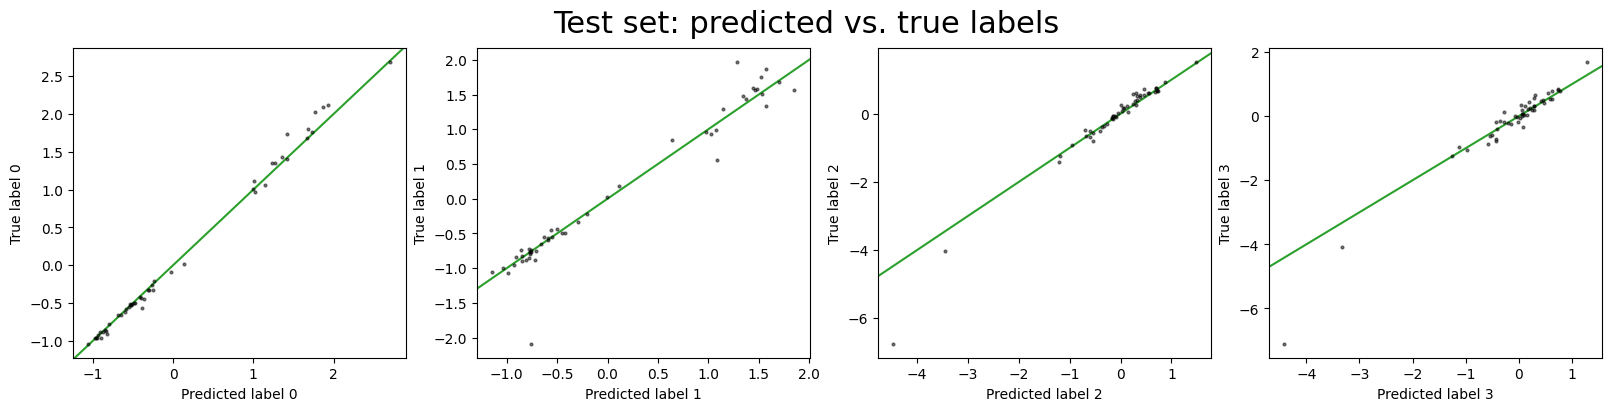

In [90]:
fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(predict_test_values["label"].shape[1]):
    axes[i].plot(
        predict_test_values["label"][:, i], test_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i}", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Test set: predicted vs. true labels", fontsize=22)

plt.show()

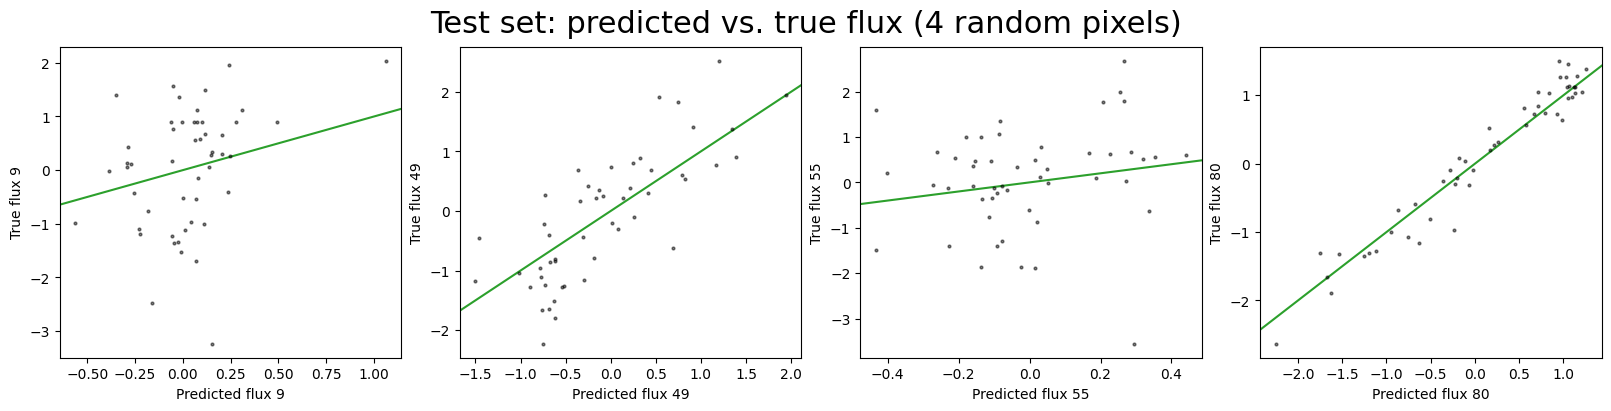

In [91]:
fig, axes = plt.subplots(
    1, len(pixel_idx), figsize=(4 * n_labels, 4), layout="constrained"
)
for i, j in enumerate(pixel_idx):
    axes[i].plot(
        predict_test_values["flux"][:, j], test_data["flux"].data[:, j], **pt_style
    )
    axes[i].set(xlabel=f"Predicted flux {j}", ylabel=f"True flux {j}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle(
    f"Test set: predicted vs. true flux ({len(pixel_idx)} random pixels)",
    fontsize=22,
)

plt.show()

Good, the model still seems to be working well on the test set data. We can now quantitatively evaluate the model performance by comparing the predicted labels and spectra with the true values.

The raw, predicted labels and spectra are in the pre-processed domain, so we need to apply the inverse transform of the pre-processors to get the predicted labels and spectra in the original data domain (to compare to the true data):

In [81]:
predict_test_unprocessed = test_data.unprocess(predict_test_values)

The prediction error for the labels:

In [82]:
#np.std(predict_test_unprocessed["label"].data - truth["label"][n_stars // 2 :], axis=0)

And the mean prediction error for the fluxes (across all pixels):

In [83]:
#np.mean(
#    np.std(
#        predict_test_unprocessed["flux"].data - truth["flux"][n_stars // 2 :], axis=0
#    )
#)

## Optimize for latents with partial data

In real world cases with spectroscopic data, we will likely want to instead use the model to predict labels for sources that only have spectra and not labels. In this case, we can optimize the latent vectors for the test set data using only the spectra and not the labels. We can do this by now also specifying the `names` argument to the {py:meth}`~pollux.models.LuxModel.optimize` method to specify what output (and therefore data) blocks to use during optimization. In this case, we will specify only the `flux` name:

In [84]:
flux_only_data = plx.data.PolluxData(flux=test_data["flux"])

In [85]:
test_opt_pars_flux, _ = model.optimize(
    flux_only_data,
    rng_key=jax.random.PRNGKey(12345),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    fixed_pars=fixed_pars,
    names=["flux"],
    svi_run_kwargs={"progress_bar": False},
)

In [86]:
predict_test_values_flux = model.predict_outputs(
    test_opt_pars_flux["latents"], opt_pars
)
predict_test_unprocessed_flux = test_data.unprocess(predict_test_values_flux)

We now have optimized latent vectors for the test set data using only the spectral flux data. We can now compare the predict labels with the true labels:

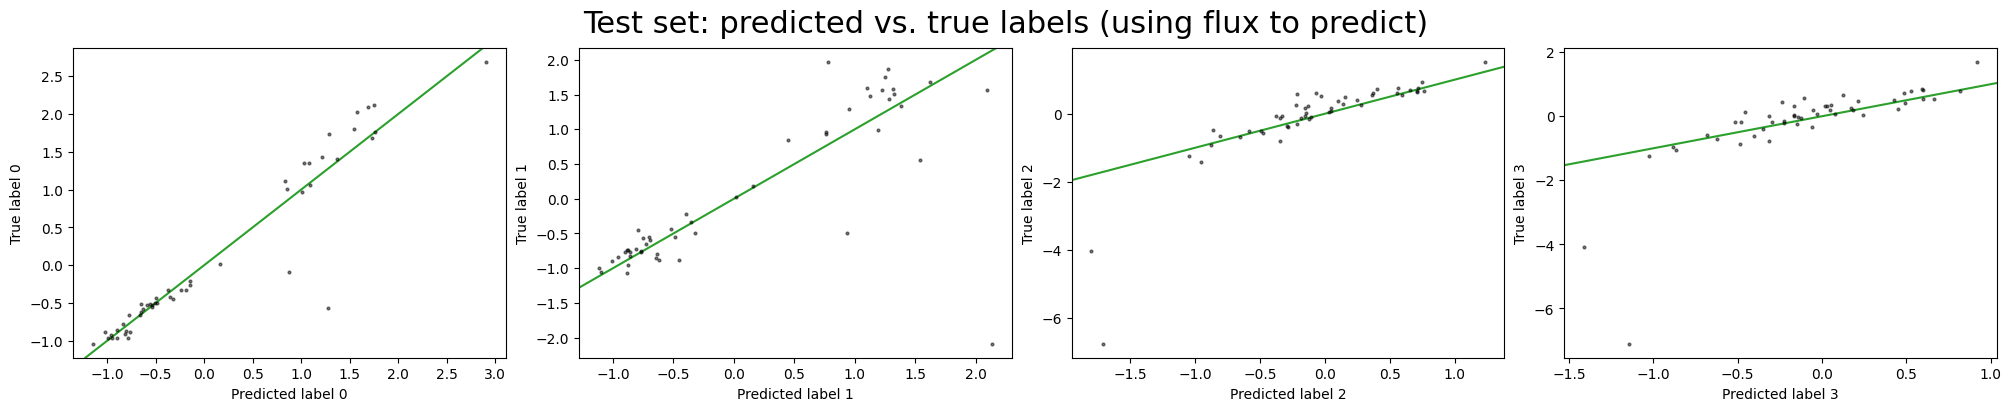

In [87]:
fig, axes = plt.subplots(1, n_labels, figsize=(20, 4), layout="constrained")
for i in range(predict_test_values_flux["label"].shape[1]):
    axes[i].plot(
        predict_test_values_flux["label"][:, i],
        test_data["label"].data[:, i],
        **pt_style,
    )
    axes[i].set(xlabel=f"Predicted label {i}", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle(
    "Test set: predicted vs. true labels (using flux to predict)", fontsize=22
)

plt.show()

In [88]:
#np.std(
#    predict_test_unprocessed_flux["label"].data - truth["label"][n_stars // 2 :], axis=0
#)

Compared to the case above where we used both the labels and spectra to optimize the latent vectors for the test set, the prediction error is _slightly_ higher when using only the spectra, as we would expect: the model has less information to constrain the latent vectors.

## Conclusion

This concludes this first tutorial on using the {py:class}`~pollux.models.LuxModel` class to define a _Lux_ model with two linear outputs. We have demonstrated how to define the model, optimize the parameters, and evaluate the model performance on test data. Many aspects of the model structure and how the model is used are customizable, as described in the [_Lux_ paper](https://arxiv.org/abs/2502.01745). For example, we can use different (more complex) transformations that map the latent vectors to outputs (e.g., Gaussian process or multi-layer perceptron), or we could use the model in a probabilistic context to perform the train/test application in a single hierarchical inference. We hope to explore these extensions in future tutorials (contributions are welcome!).